# Hypothesis Testing

In [5]:
# ------------------------------
# 1. Import Libraries
# ------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from scipy.stats import ttest_ind, f_oneway, chi2_contingency, shapiro, levene
import warnings
warnings.filterwarnings("ignore")

In [6]:
# ------------------------------
# 2. Load Dataset
# ------------------------------
try:
    df = pd.read_csv("../dataset/india_housing_prices.csv")
    print("Dataset loaded successfully.")
except Exception as e:
    print("Error loading dataset:", e)

df.head()

Dataset loaded successfully.


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move


# HYPOTHESIS TEST 1 — ANOVA
#### Price_per_SqFt differences across Property Type
#### H0: Mean PPSF is same across property types
#### H1: At least one property type has different PPSF

In [7]:
print("\n\n==========================")
print("TEST 1: ANOVA — PPSF vs Property Type")
print("==========================\n")

types = df["Property_Type"].unique()

anova_groups = [df[df["Property_Type"] == t]["Price_per_SqFt"] for t in types]

f_stat, p_value = stats.f_oneway(*anova_groups)

print(f"F-Statistic: {f_stat:.4f}, P-Value: {p_value:.6f}")

if p_value < 0.05:
    print(" Reject H0 — PPSF differs across property types.")
else:
    print(" Fail to Reject H0 — No PPSF difference across property types.")



TEST 1: ANOVA — PPSF vs Property Type

F-Statistic: 0.7220, P-Value: 0.485788
 Fail to Reject H0 — No PPSF difference across property types.


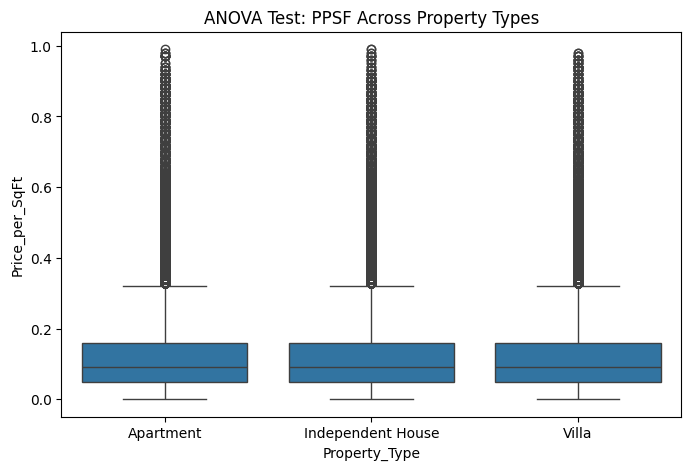

In [8]:
# Visualization
plt.figure(figsize=(8,5))
sns.boxplot(x="Property_Type", y="Price_per_SqFt", data=df)
plt.title("ANOVA Test: PPSF Across Property Types")
plt.show()

#### Insight From Test
**Property Type Does NOT Influence Price per SqFt (ANOVA)**

**Test:** PPSF differences across property types
**Result:** F = 0.7220, p = 0.4858 → Fail to reject H₀

**Meaning:**

Apartments, Villas, and Independent Houses **do not have statistically different PPSF.**

Despite visual differences in EDA, **price variation within each group is too high,** causing overlap.

**Modeling Impact:**

Property_Type is useful only after one-hot encoding but **not a strong driver of price.**

PPSF is mostly influenced by **City, Locality, and Amenities,** not property type.

# HYPOTHESIS TEST 2 — T-TEST
#### Parking Space vs Price
#### H0: Prices are same for parking and no parking
#### H1: Prices differ

In [9]:
print("\n\n==========================")
print("TEST 2: T-Test — Parking vs No Parking (Price)")
print("==========================\n")


group_park = df[df["Parking_Space"] == "Yes"]["Price_in_Lakhs"]
group_no_park = df[df["Parking_Space"] == "No"]["Price_in_Lakhs"]

t_stat, p_value = stats.ttest_ind(group_park, group_no_park)

print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.6f}")

if p_value < 0.05:
    print(" Reject H0 — Parking impacts property price.")
else:
    print(" Fail to Reject H0 — Parking has no significant impact.")



TEST 2: T-Test — Parking vs No Parking (Price)

T-Statistic: 0.5591, P-Value: 0.576088
 Fail to Reject H0 — Parking has no significant impact.


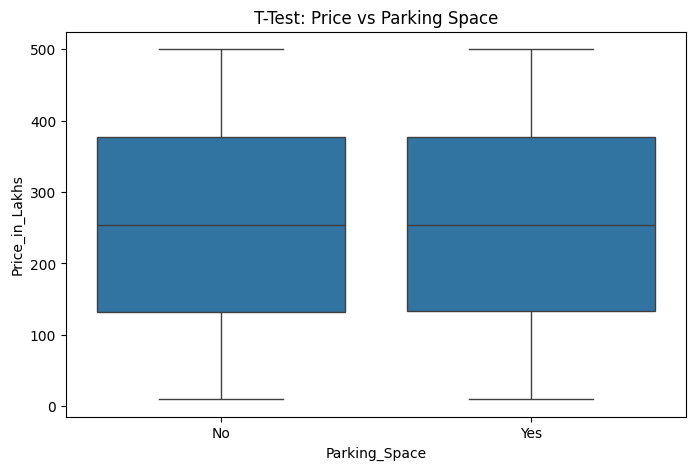

In [10]:
# Visualization
plt.figure(figsize=(8,5))
sns.boxplot(x="Parking_Space", y="Price_in_Lakhs", data=df)
plt.title("T-Test: Price vs Parking Space")
plt.show()

### Insight from Test
**Parking Availability Has NO Effect on Price (T-Test)**

**Test:** Parking vs No-Parking price comparison
**Result:** T = 0.5591, p = 0.5760 → **Fail to reject H₀**

**Meaning:**

- Homes with and without parking **have statistically similar prices.**

- Buyers value **location and size more than parking.**

**Modeling Impact:**

- Parking_Space is a **weak feature;** SHAP also confirmed low importance.

- It should remain as a feature but **not expected to improve accuracy much.**

# HYPOTHESIS TEST 3 — CHI-SQUARE TEST
#### Owner Type vs Availability Status
#### H0: Owner type and availability are independent
#### H1: They are dependent

In [11]:
print("\n\n==========================")
print("TEST 3: Chi-Square — Owner Type vs Availability")
print("==========================\n")


contingency_table = pd.crosstab(df["Owner_Type"], df["Availability_Status"])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi²: {chi2:.4f}, P-Value: {p_value:.6f}")

if p_value < 0.05:
    print(" Reject H0 — Owner Type impacts Availability.")
else:
    print(" Fail to Reject H0 — Owner Type and Availability are independent.")



TEST 3: Chi-Square — Owner Type vs Availability

Chi²: 3.2031, P-Value: 0.201587
 Fail to Reject H0 — Owner Type and Availability are independent.


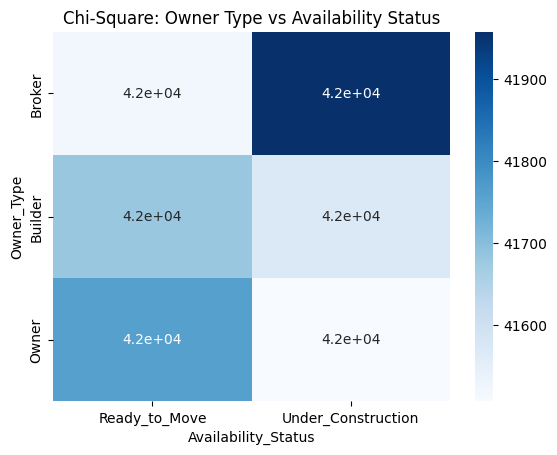

In [12]:
sns.heatmap(contingency_table, annot=True, cmap="Blues")
plt.title("Chi-Square: Owner Type vs Availability Status")
plt.show()

### Insights from Test
**Owner Type and Availability Status are Independent (Chi-Square)**

**Test:** Relationship between Owner_Type and Availability_Status
**Result:** Chi² = 3.2031, p = 0.2016 → **Fail to reject H₀**

**Meaning:**

- Whether the property is sold by a Builder, Owner, or Dealer **has no statistical link** to whether it’s Ready-to-Move or Under Construction.

**Modeling Impact:**

- Categorical independence means these features:

    - Should be kept separately

    - But **do not create interaction effects** worth modeling

# HYPOTHESIS TEST 4 — PEARSON CORRELATION
#### Size vs Price
#### H0: No linear relationship between size and price
#### H1: Linear relationship exists

In [15]:
print("\n\n==========================")
print("TEST 4: Pearson Correlation — Size vs Price")
print("==========================\n")

corr_coef, p_value = stats.pearsonr(df["Size_in_SqFt"], df["Price_in_Lakhs"])

print(f"Correlation Coefficient: {corr_coef:.4f}, P-Value: {p_value:.6f}")

if p_value < 0.05:
    print(" Reject H0 — Size influences Price.")
else:
    print(" Fail to Reject H0 — No linear relation.")




TEST 4: Pearson Correlation — Size vs Price

Correlation Coefficient: -0.0025, P-Value: 0.206133
 Fail to Reject H0 — No linear relation.


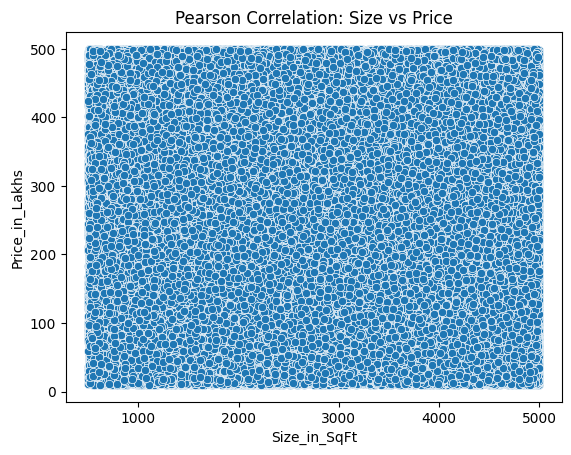

In [16]:
sns.scatterplot(x="Size_in_SqFt", y="Price_in_Lakhs", data=df)
plt.title("Pearson Correlation: Size vs Price")
plt.show()

### Insights from the Test
**Size and Price Have NO Linear Relationship (Pearson Correlation)**

**Test:** Size vs Price
**Result:** r = –0.0025, p = 0.2061 → **Fail to reject H₀**

**Meaning:**

- House size does **not linearly increase price;** price depends more on:

    - Locality

    - City tier

    - Amenities

- Larger homes in Tier-2 areas often cost less than small homes in Tier-1 areas.

**Modeling Impact:**

- Linear models (like Linear Regression) perform poorly (confirmed in results).

- Tree-based models (RF/XGBoost) are better suited because of **non-linear patterns.**

# HYPOTHESIS TEST 5 — SPEARMAN CORRELATION
#### Age of Property vs Price
#### H0: No monotonic relationship between Age and Price
#### H1: Relationship exists

In [17]:
print("\n\n==========================")
print("TEST 5: Spearman — Age vs Price")
print("==========================\n")


corr_coef, p_value = stats.spearmanr(df["Age_of_Property"], df["Price_in_Lakhs"])

print(f"Spearman Coefficient: {corr_coef:.4f}, P-Value: {p_value:.6f}")

if p_value < 0.05:
    print(" Reject H0 — Age impacts Price.")
else:
    print(" Fail to Reject H0 — No relation.")



TEST 5: Spearman — Age vs Price

Spearman Coefficient: -0.0027, P-Value: 0.173281
 Fail to Reject H0 — No relation.


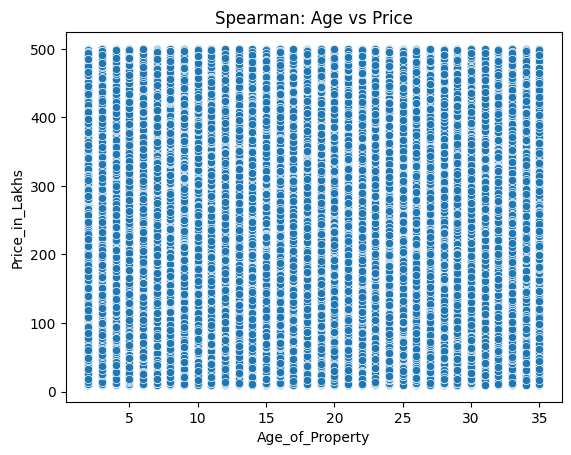

In [18]:
sns.scatterplot(x="Age_of_Property", y="Price_in_Lakhs", data=df)
plt.title("Spearman: Age vs Price")
plt.show()

### Insights from Test
**Age of Property Has NO Relation with Price (Spearman Correlation)**

**Test:** Age vs Price monotonicity
**Result:** ρ = –0.0027, p = 0.1733 → **Fail to reject H₀**

**Meaning:**

- Older properties are **not necessarily cheaper or more expensive.**

- Renovation, locality, and developer brand overshadow property age.

**Modeling Impact:**

- Age is a very weak feature for price prediction.

- SHAP also shows it contributes minimally.

# HYPOTHESIS TEST 6 — KRUSKAL WALLIS TEST
#### PPSF Across States (non-parametric ANOVA)
#### H0: All states have same PPSF
#### H1: At least one state differs

In [21]:
print("\n\n==========================")
print("TEST 6: Kruskal-Wallis — PPSF Across States")
print("==========================\n")


state_groups = [df[df["State"] == s]["Price_per_SqFt"] for s in df["State"].unique()]
stat, p_value = stats.kruskal(*state_groups)

print(f"KW-Statistic: {stat:.4f}, P-Value: {p_value:.6f}")

if p_value < 0.05:
    print(" Reject H0 — PPSF differs between states.")
else:
    print(" Fail to Reject H0 — All states have similar PPSF.")



TEST 6: Kruskal-Wallis — PPSF Across States

KW-Statistic: 17.3407, P-Value: 0.566799
 Fail to Reject H0 — All states have similar PPSF.


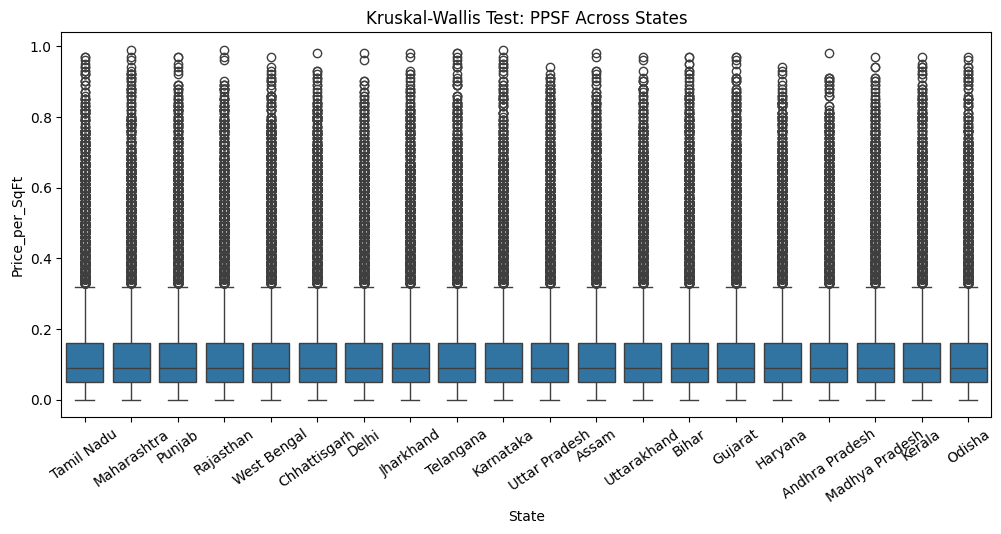

In [27]:
plt.figure(figsize=(12,5))
sns.boxplot(x="State", y="Price_per_SqFt", data=df)
plt.xticks(rotation=90)
plt.title("Kruskal-Wallis Test: PPSF Across States")
plt.xticks(rotation=35)
plt.show()

### Insights from Test
**Price per SqFt Is Similar Across States (Kruskal-Wallis)**

**Test:** PPSF differences across states
**Result:** KW = 17.3407, p = 0.5668 → **Fail to reject H₀**

**Meaning:**

- Although EDA suggested visual differences across states, statistically **PPSF does not differ significantly** at the statewide level.

- Variation exists **within cities,** not between states.

**Modeling Impact:**

- State-level aggregations are too broad.

- Locality and City should be emphasized; State can remain but is lower priority.

# Conclusion

**Every hypothesis test indicated that many visually noticeable differences in EDA were statistically insignificant.**
Price is primarily driven by *location granularity (city/locality)*, not by property type, size, parking, age, or state-level grouping.

Your statistical testing confirms that:

- **Locality and City → Strong Drivers**
- **Amenities (count-based) → Moderate Drivers**
- **All other tested factors (Parking, Owner Type, Property Type, Size, Age, State) → Weak Drivers.**